In [57]:
import tensorflow as tf
print(tf.__version__)

2.9.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [58]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [59]:
# Save the input and target variables
# print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]


In [60]:
# Normalise the target data (this will make clearer training curves)
# targets[:10]

targets = (targets - targets.mean(axis=0)) / targets.std()

targets[:10]

array([-0.01471948, -1.00165882, -0.14457991,  0.69951294, -0.22249618,
       -0.71596585, -0.18353805, -1.15749134, -0.54714728,  2.05006151])

In [61]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape), print(test_data.shape), print(train_targets.shape), print(test_targets.shape)


(397, 10)
(45, 10)
(397,)
(45,)


(None, None, None, None)

#### Train a feedforward neural network model

In [62]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(1)
  ])
  return model

model = get_model()


In [63]:
# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1408      
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dense_41 (Dense)            (None, 1)                

In [64]:
# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=["mae"])


In [65]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)


In [66]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets)


2/2 [==============================] - 0s 10ms/step - loss: 1.1864 - mae: 0.8016


[1.1864445209503174, 0.801569938659668]

#### Plot the learning curves

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

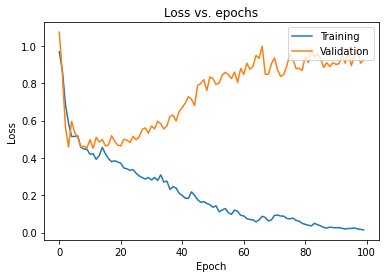

In [68]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [69]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [70]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [71]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [72]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) 


In [73]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets,
                    epochs=100,
                    validation_split=0.15,
                    batch_size=64,
                    verbose=False)


In [74]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.8690 - mae: 0.7243 - 18ms/epoch - 9ms/step


[0.8689606785774231, 0.7243281006813049]

#### Plot the learning curves

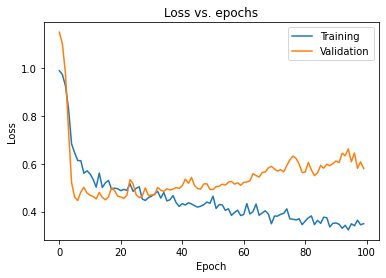

In [75]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [76]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  
  def on_train_begin(self, logs=None):
    print("starting training...")

  def on_epoch_begin(self, epoch, logs=None):
    print(f"Starting epoch {epoch}")
  
  def on_train_batch_begin(self, batch, log=None):
    print(f"Training: Starting batch {batch}")

  def on_train_batch_end(self, batch, logs=None):
    print(f"Training: Finished batch {batch}")

  def on_epoch_end(self, epoch, logs=None):
    print(f"Training: Finished epoch {epoch}")

  def on_train_end(self, logs=None):
    print("Finished training")

class TestingCallback(Callback):

  def on_test_begin(self, logs=None):
    print("starting testing...")

  def on_test_batch_begin(self, batch, log=None):
    print(f"Testing: Starting batch {batch}")

  def on_test_batch_end(self, batch, logs=None):
    print(f"Testing: Finished batch {batch}")

  def on_test_end(self, logs=None):
    print("Finished testing")

class PredictionCallback(Callback):
  def on_predict_begin(self, logs=None):
    print("starting prediction...")

  def on_predict_batch_begin(self, batch, log=None):
    print(f"Predicting: Starting batch {batch}")

  def on_predict_batch_end(self, batch, logs=None):
    print(f"Prediicting: Finished batch {batch}")

  def on_predict_end(self, logs=None):
    print("Finished Predicting")

# class my_callback(Callback):

#   def on_train_begin(self, logs=None):
#     # Do something at the start of training

#   def on_train_batch_begin(self, batch, logs=None):
#     # Do something at the start of every batch iteration (training only)
#   def on_epoch_end(self, epoch, logs=None):
#     # Do something at end of each epoch



In [77]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [78]:
# Compile the model
model.compile(optimizer="adam", loss="mse")


#### Train the model with the callback

In [79]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets,
          epochs=3,
          batch_size=128,
          verbose=False,
          callbacks=[TrainingCallback()])

starting training...
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Training: Finished epoch 2
Finished training


In [80]:
# Evaluate the model
model.evaluate(test_data, test_targets, callbacks=[TestingCallback()])


starting testing...
Testing: Starting batch 0
Testing: Finished batch 0
1/2 [==============>...............] - ETA: 0s - loss: 0.9055Testing: Starting batch 1
Testing: Finished batch 1
Finished testing
2/2 [==============================] - 0s 6ms/step - loss: 0.8678


0.8678058981895447

In [81]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])


starting prediction...
Predicting: Starting batch 0
Prediicting: Finished batch 0
Predicting: Starting batch 1
Prediicting: Finished batch 1
Finished Predicting


array([[ 0.03729869],
       [-0.00429203],
       [-0.01781858],
       [ 0.01837664],
       [ 0.06162151],
       [ 0.01009855],
       [ 0.07154232],
       [ 0.05082674],
       [ 0.06054411],
       [ 0.06205559],
       [ 0.00654787],
       [ 0.00171834],
       [ 0.01677552],
       [-0.00778991],
       [ 0.06530564],
       [ 0.00692164],
       [ 0.08739871],
       [ 0.00387611],
       [ 0.07223918],
       [ 0.07071346],
       [ 0.06890349],
       [ 0.0393135 ],
       [ 0.0538344 ],
       [-0.00725454],
       [ 0.00624844],
       [ 0.05898315],
       [ 0.00745055],
       [ 0.06692943],
       [ 0.04635187],
       [ 0.07265247],
       [ 0.02675001],
       [ 0.00741385],
       [ 0.06554241],
       [ 0.0376532 ],
       [ 0.06772104],
       [ 0.00548338],
       [ 0.04042875],
       [ 0.06212533],
       [ 0.05384296],
       [-0.00840316],
       [ 0.05449552],
       [ 0.02730834],
       [ 0.05189755],
       [ 0.01140764],
       [ 0.05487116]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [102]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, 
                                         epochs=100,
                                         validation_split=0.15,
                                         batch_size=64,
                                         verbose=False,
                                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])


In [103]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.6371 - 30ms/epoch - 15ms/step


0.6370847225189209

In [110]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, 
                                         epochs=100,
                                         validation_split=0.15,
                                         batch_size=64,
                                         verbose=False,
                                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])


In [111]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)



2/2 - 0s - loss: 0.6788 - 19ms/epoch - 9ms/step


0.6788408756256104

#### Plot the learning curves

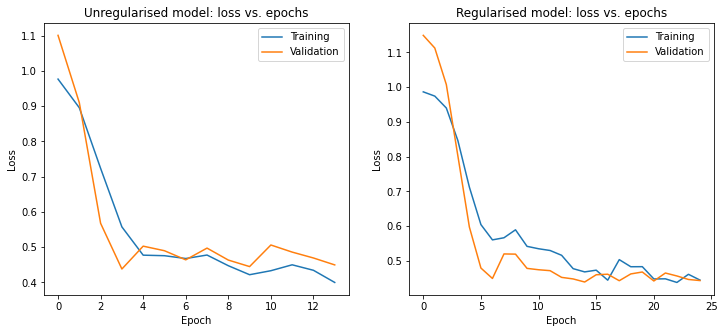

In [112]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()